In [15]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL.ImageDraw import Draw

from anipaint import find_edge_distance, find_directions, cached_edge_distance, composite

shared_datadir = Path(r"D:\OneDrive\programs\anipaint\anipaint\tests\data")
tmp_path = Path(r"m:/deldir/anipaint/tests")

logging.basicConfig(level=logging.INFO)
plt.rcParams['figure.figsize'] = [12, 8]

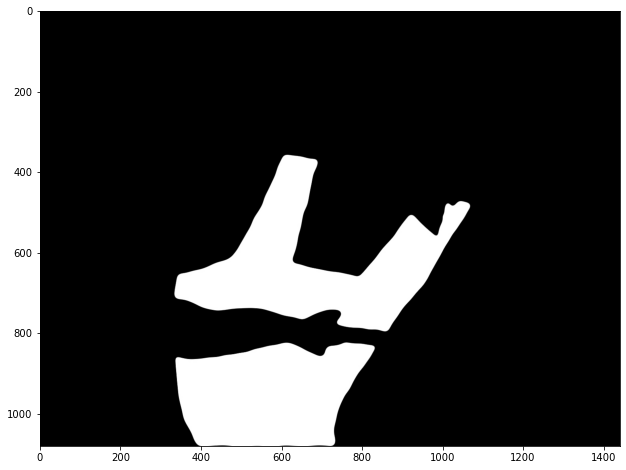

In [57]:
# open a matte
matte_file = "Comp 2/ShirtMAtte_00000.jpg"
matte_path = shared_datadir / matte_file
cache_path = shared_datadir / "Comp 2/cache"
matte_image = Image.open(matte_path)
plt.imshow(matte_image)
plt.show()
assert matte_image.mode == "RGB", f"Expect images to be RGB, not {matte_image.mode}"
rgb_array = np.array(matte_image)

In [19]:
# References:
#  https://stackoverflow.com/questions/48585468/vectorize-conways-game-of-life-in-pure-numpy
#  Search this more: cellular automata numpy
#  Also look at image kernels and implementing guassian, etc blur
#  Also look for libraries
#  https://datacarpentry.org/image-processing/08-edge-detection/
#  https://jessicastringham.net/2017/12/31/stride-tricks/ -- Implementing convolutions with stride_tricks
#  https://setosa.io/ev/image-kernels/


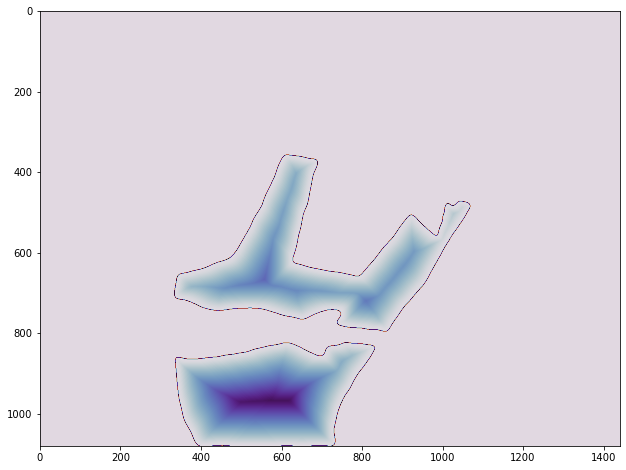

In [8]:
edge_distance = cached_edge_distance(matte_path,cache_path)
plt.imshow(np.where(edge_distance==0,256,edge_distance),cmap='twilight', vmin=0, vmax=255) # https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.show()

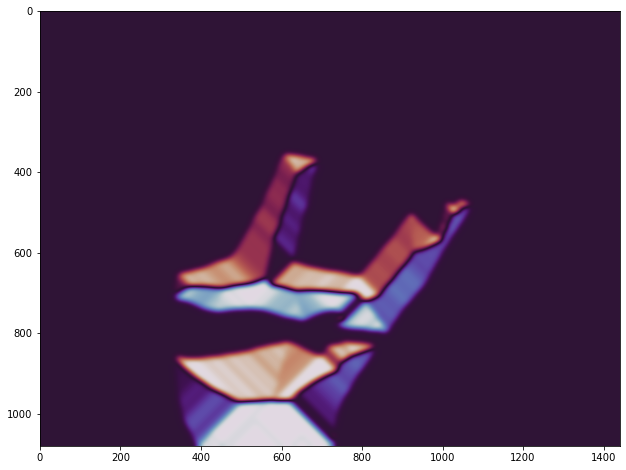

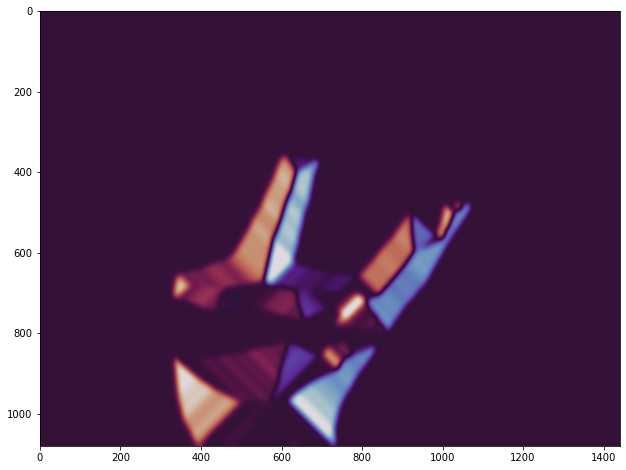

In [9]:
directions = find_directions(edge_distance)
plt.imshow(directions[0],cmap='twilight')
plt.show()
plt.imshow(directions[1],cmap='twilight')
plt.show()

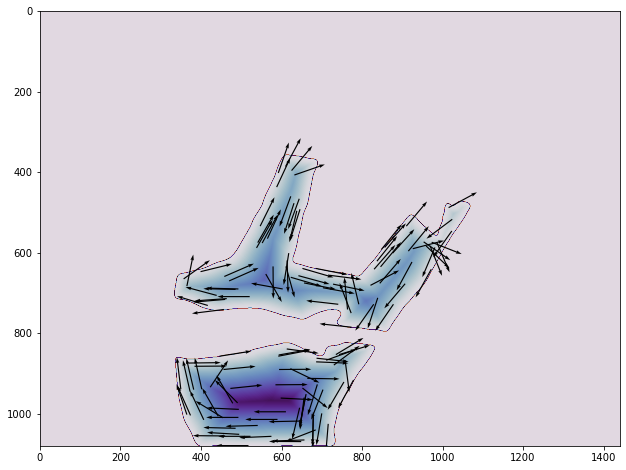

In [10]:
import math

random_count = 1000

rng = np.random.RandomState(seed=231) # random number generator
rand_x=rng.randint(0,edge_distance.shape[0],random_count)
rand_y=rng.randint(0,edge_distance.shape[1],random_count)
plt.imshow(np.where(edge_distance==0,256,edge_distance),cmap='twilight', vmin=0, vmax=255)
for i in range(random_count):
    x,y = rand_x[i],rand_y[i]
    v = edge_distance[x,y]
    if v==0:
        continue
    dx,dy = directions[0][x,y],directions[1][x,y]
    angle = math.atan2(dy,dx)-math.pi/2
    dxr,dyr = math.cos(angle),math.sin(angle)
    # print(x,y,v,dx,dy)
    # plt.plot(y,x,"o")
    plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)
plt.show()    

(3675,)
(array([ 386,  386,  386, ..., 1055, 1055, 1055], dtype=int64), array([627, 628, 629, ..., 572, 573, 574], dtype=int64))


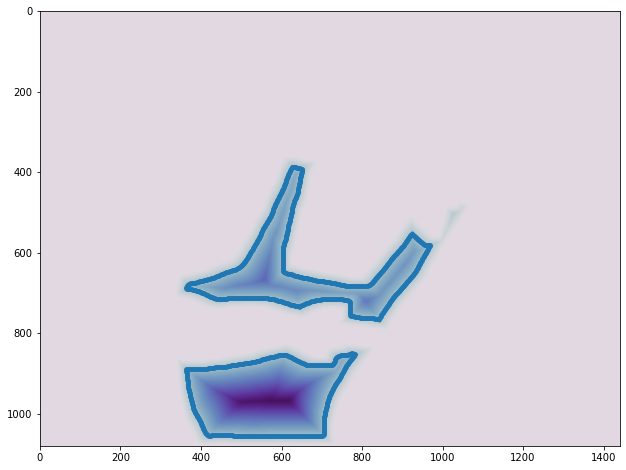

In [11]:
# Where to put next EDGE brushstroke.

how_far_in = 25 # This could be a little random and based on width of stroke

candidates = np.nonzero(edge_distance==how_far_in)
print(candidates[0].shape)
print(candidates)

plt.imshow(edge_distance,cmap='twilight', vmin=0, vmax=255)
plt.plot(candidates[1],candidates[0],".")
plt.show()

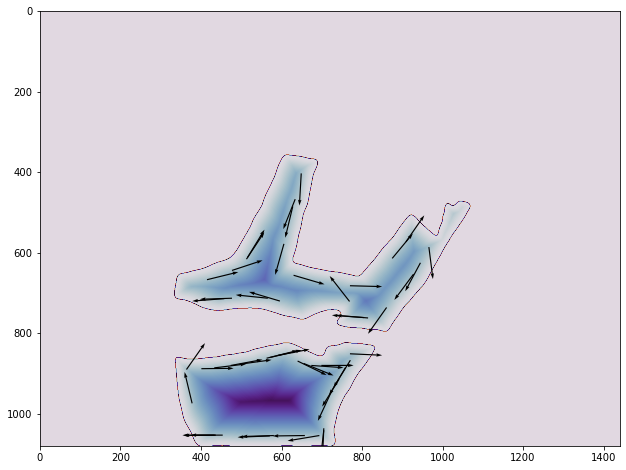

In [12]:
random_count = 50

rng = np.random.RandomState(seed=231) # random number generator
plt.imshow(np.where(edge_distance==0,256,edge_distance),cmap='twilight', vmin=0, vmax=255)
for _ in range(random_count):
    i = rng.choice(len(candidates[1]))
    x,y = candidates[0][i],candidates[1][i]
    dx,dy = directions[0][x,y],directions[1][x,y]
    angle = math.atan2(dy,dx)-math.pi/2
    dxr,dyr = math.cos(angle),math.sin(angle)
    #print(x,y,v,dx,dy)
    #plt.plot(y,x,"o")
    plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)
plt.show() 

RGBA


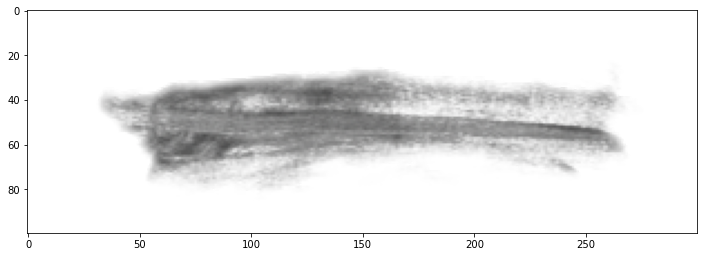

In [13]:
brush_file = "brushes/PaintStrokes (0-00-00-04).png"
brush_path = shared_datadir / brush_file
brush_image = Image.open(brush_path)
assert brush_image.mode == "RGBA", f"Expect images to be RGBA, not {brush_image.mode}"
print(brush_image.mode)
plt.imshow(brush_image)

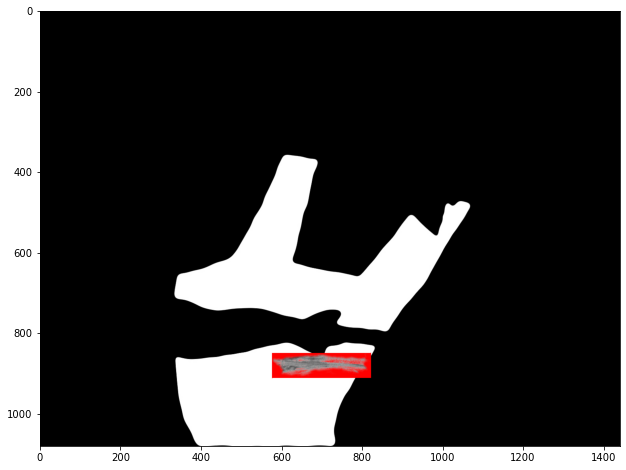

In [16]:
im1 = composite(matte_image,brush_image,y,x,-math.degrees(math.atan2(dy,dx)),sprite_factor=1,draw_debug_line=True)
plt.imshow(im1)
plt.show()

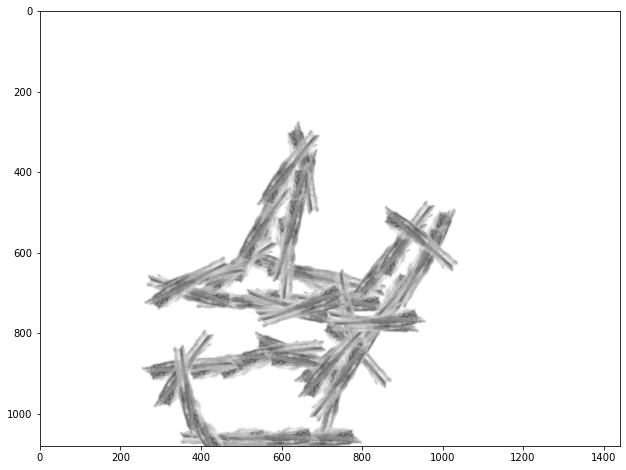

In [71]:
how_far_in = 20 # This could be a little random and based on width of stroke
random_count = 100
show_work = False
keep_threshold = 500_000

candidates = np.nonzero(edge_distance==how_far_in)


if show_work:
    plt.rcParams['figure.figsize'] = [6, 4]
else:    
    plt.rcParams['figure.figsize'] = [12, 8]

rng = np.random.RandomState(seed=231) # random number generator
im1 = Image.new("RGBA", matte_image.size, (0,0,0,0))
old_sum = int(np.array(im1).sum())
for _ in range(random_count):
    i = rng.choice(len(candidates[1]))
    x,y = candidates[0][i],candidates[1][i]
    dx,dy = directions[0][x,y],directions[1][x,y]
    angle = math.atan2(dy,dx)-math.pi/2
    dxr,dyr = math.cos(angle),math.sin(angle)
    im2 = composite(im1,brush_image,y,x,-math.degrees(math.atan2(dy,dx)),sprite_factor=1,draw_debug_line=False)
    new_sum = int(np.array(im2).sum())
    diff = new_sum-old_sum
    #{old_sum:,}-{new_sum:,}=
    if show_work:
            print(f"{diff:,}")
            plt.plot(y,x,"o")
            #plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)    
            plt.imshow(im2)
            plt.show()
    if diff > keep_threshold:
        old_sum = new_sum
        im1=im2
    elif show_work:
         print("don't keep")
#plt.imshow(im1)
im1.save(tmp_path / f"edge{how_far_in}_{random_count}_{keep_threshold}.png")
plt.imshow(im1)
plt.show()

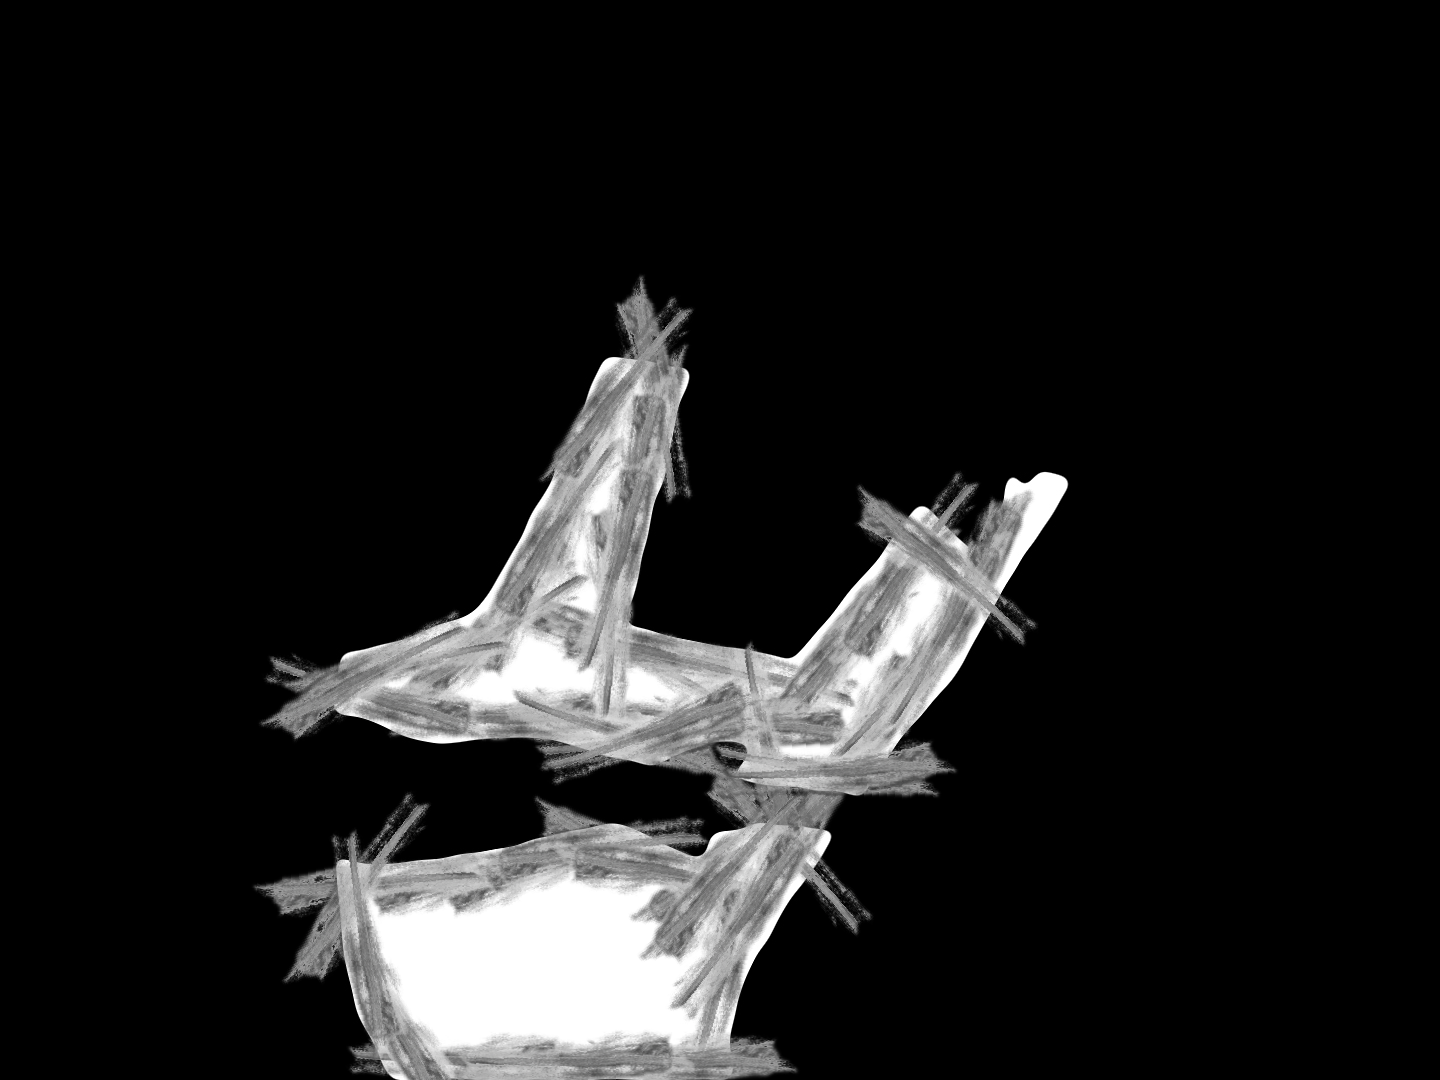

In [72]:
im3 = matte_image.copy()
im3.paste(im1,(0,0),im1)
im3.save(tmp_path / f"edgeC{how_far_in}_{random_count}_{keep_threshold}.png")
im3

In [25]:
f"{np.array(im1).sum():,}"

'137,916,744'

In [ ]:
random_count = 50
rng = np.random.RandomState(seed=231) # random number generator
im1 = matte_image.copy()
for _ in range(random_count):
    i = rng.choice(len(candidates[1]))
    x,y = candidates[0][i],candidates[1][i]
    dx,dy = directions[0][x,y],directions[1][x,y]
    angle = math.atan2(dy,dx)-math.pi/2
    dxr,dyr = math.cos(angle),math.sin(angle)
    im1 = composite(im1,brush_image,y,x,-math.degrees(math.atan2(dy,dx)),sprite_factor=1,draw_debug_line=False)
    #plt.plot(y,x,"o")
    #plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)    
#plt.imshow(im1)
im1.save(tmp_path / "edge50.png")
im1